import Libraries , Reading ,and Gettting Informations


In [85]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

In [86]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [87]:
print(train.shape)

(188533, 13)


In [88]:
print(test.shape)

(125690, 12)


In [89]:
print("Missing values in train:\n", train.isnull().sum())
print("Missing values in test:\n", test.isnull().sum())

Missing values in train:
 id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64
Missing values in test:
 id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


Droping Duplicates

In [90]:
train.drop_duplicates(inplace=True)

Visualizations

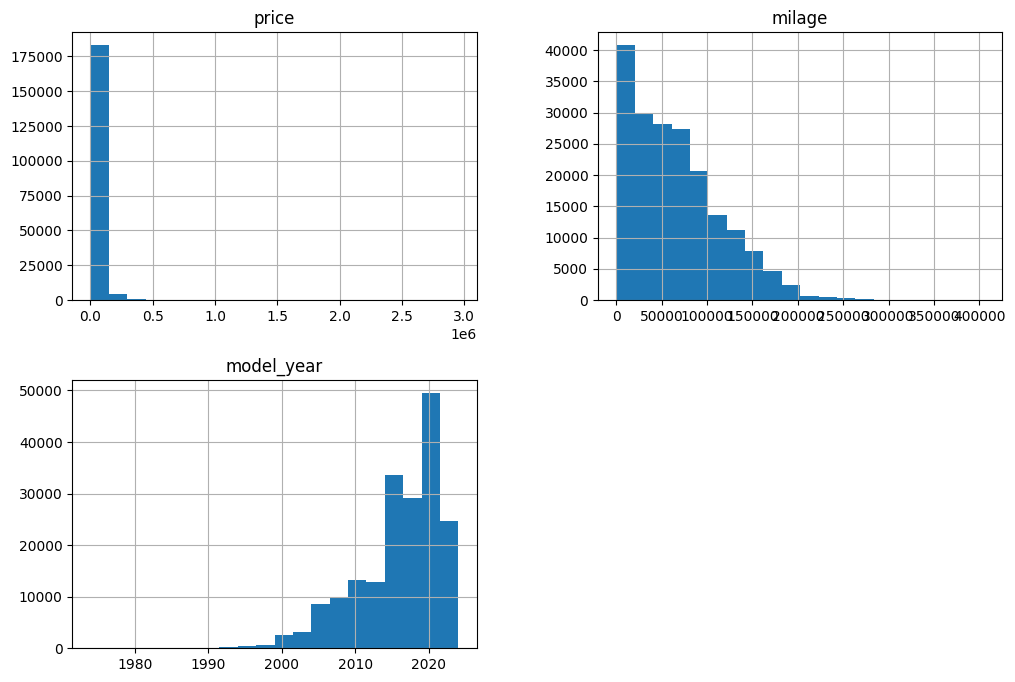

In [91]:
train[['price', 'milage', 'model_year']].hist(bins=20, figsize=(12, 8))
plt.show()

In [92]:
# sns.boxplot(x='fuel_type', y='price', data=train)
# plt.title("Price vs Fuel Type")
# plt.show()

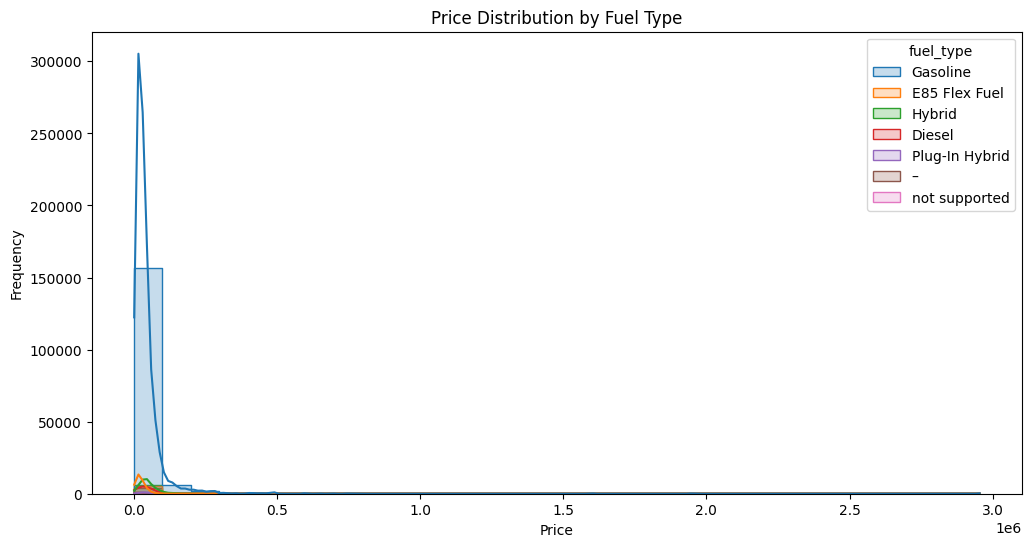

In [93]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='price', hue='fuel_type', kde=True, element='step', bins=30)
plt.title("Price Distribution by Fuel Type")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

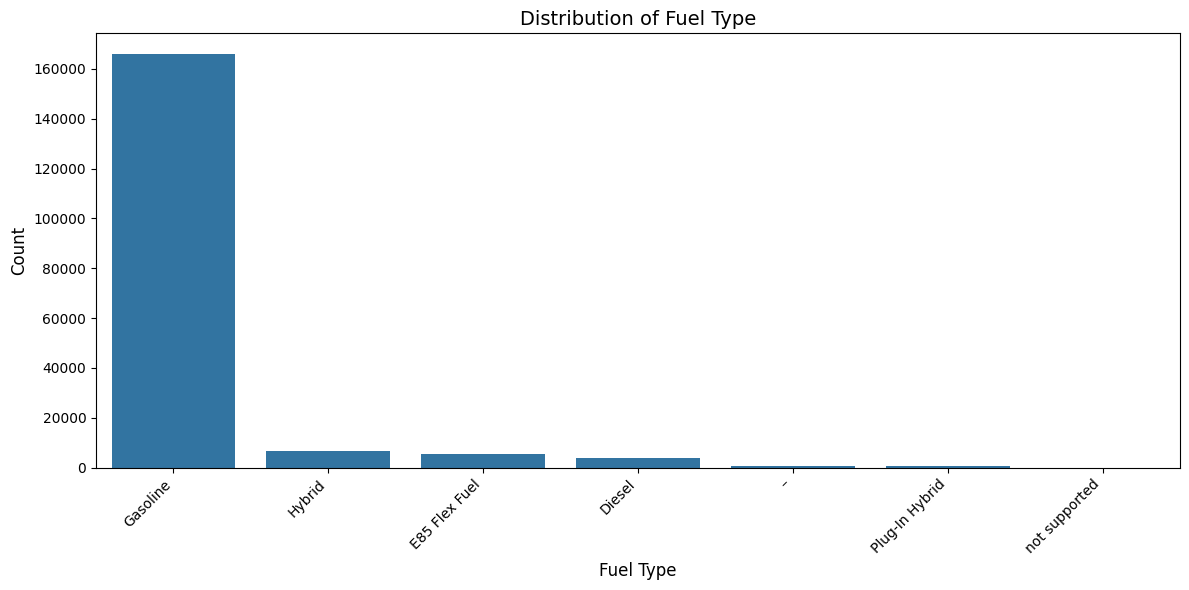

In [94]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='fuel_type', order=train['fuel_type'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Fuel Type", fontsize=14)
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()


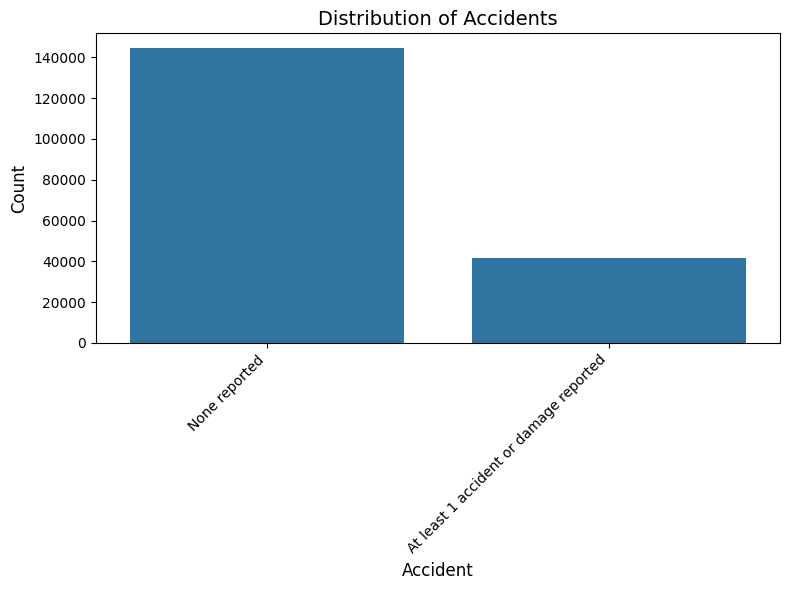

In [95]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='accident', order=train['accident'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Accidents", fontsize=14)
plt.xlabel("Accident", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

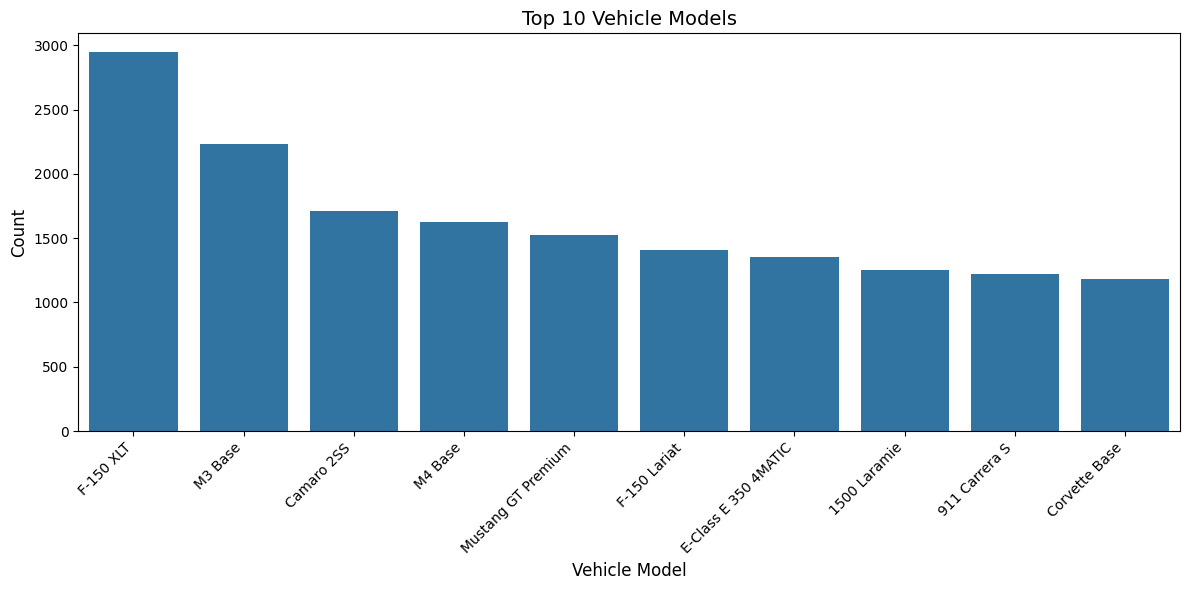

In [96]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='model', order=train['model'].value_counts().index[:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Vehicle Models", fontsize=14)
plt.xlabel("Vehicle Model", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()

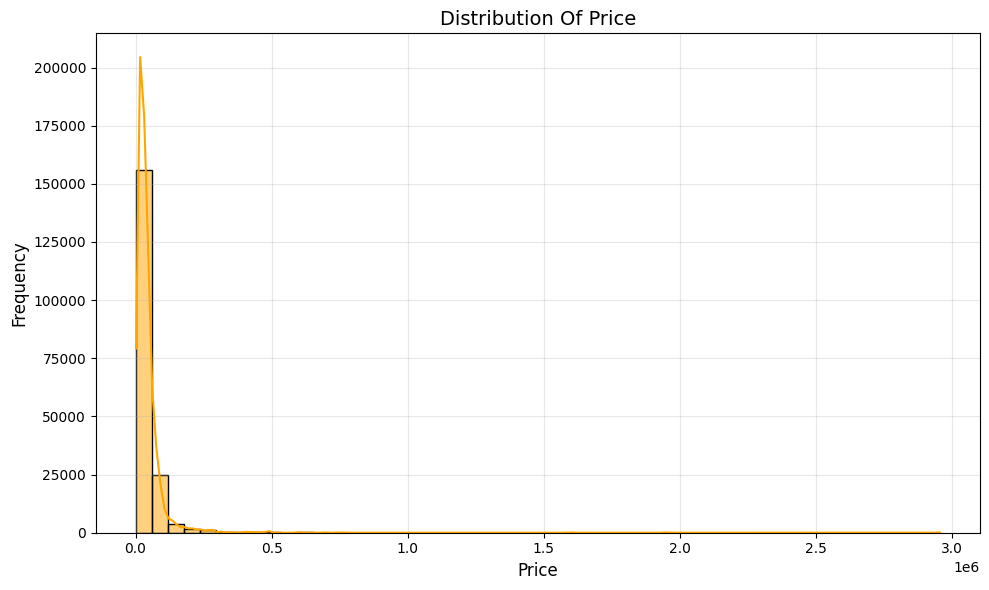

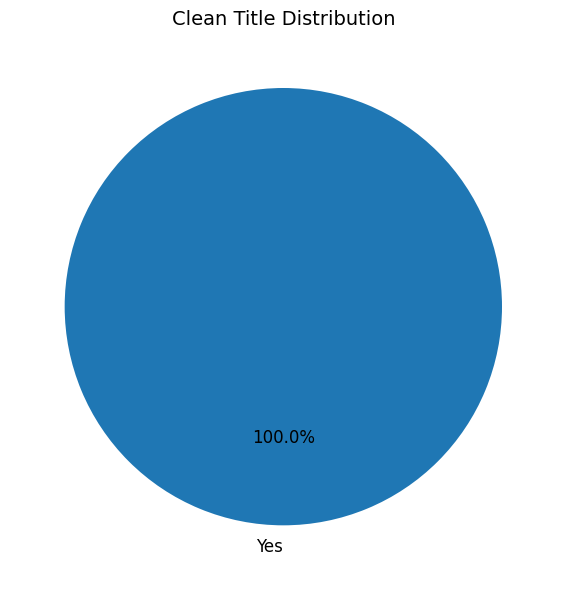

In [97]:
plt.figure(figsize=(10, 6))
sns.histplot(train['price'], bins=50, kde=True, color='orange')
plt.title("Distribution Of Price", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
clean_title_counts = train['clean_title'].value_counts()
clean_title_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12},
)
plt.title("Clean Title Distribution", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

Fill in Missing Values and Handling Iconsistencies

In [98]:
train['accident'] = train['accident'].fillna('None reported')
test['accident'] = test['accident'].fillna('None reported')

In [99]:
train['clean_title'] = train['clean_title'].fillna('Unknown')
test['clean_title'] = test['clean_title'].fillna('Unknown')

In [100]:
def fill_fuel_type(row):
    if pd.isna(row['fuel_type']):
        if 'Flex Fuel' in str(row['engine']):
            return 'E85 Flex Fuel'
        elif 'Hybrid' in str(row['engine']):
            return 'Hybrid'
        elif 'Diesel' in str(row['engine']):
            return 'Diesel'
        else:
            return 'Gasoline'
    return row['fuel_type']

train['fuel_type'] = train.apply(fill_fuel_type, axis=1)
test['fuel_type'] = test.apply(fill_fuel_type, axis=1)

In [102]:
train['fuel_type'] = train['fuel_type'].replace(['–', 'not supported', np.nan], 'Unknown')
test['fuel_type'] = test['fuel_type'].replace(['–', 'not supported', np.nan], 'Unknown')

In [103]:
train.isnull().any()

,0
id,False
brand,False
model,False
model_year,False
milage,False
fuel_type,False
engine,False
transmission,False
ext_col,False
int_col,False


In [104]:
train['fuel_type'].value_counts()

,count
fuel_type,
Gasoline,171012
Hybrid,6840
E85 Flex Fuel,5407
Diesel,3957
Unknown,796
Plug-In Hybrid,521


In [105]:
train['ext_col'].unique()
train['ext_col'].replace({'BLUE':'Blue','Blu':'Blue'})

,ext_col
0,Yellow
1,Silver
2,Blue
3,Black
4,Black
...,...
188528,White
188529,White
188530,White
188531,Daytona Gray Pearl Effect


In [106]:
train['int_col'].unique()
train['int_col'].replace({'WHITE':'White','–':'Unknown','BLACK':'Black','Blk':'Black','ORANGE':'Orange'})

,int_col
0,Gray
1,Beige
2,Gray
3,Black
4,Beige
...,...
188528,Beige
188529,Black
188530,Black
188531,Black


 Combine related categorical values (colors)


In [107]:
def group_colors(color):
    color = color.lower().strip()
    if 'black' in color:
        return 'black'
    elif 'white' in color or 'pearl' in color:
        return 'white'
    elif 'blue' in color:
        return 'blue'
    elif 'red' in color:
        return 'red'
    elif 'gray' in color or 'grey' in color:
        return 'gray'
    elif 'silver' in color:
        return 'silver'
    elif 'green' in color:
        return 'green'
    elif 'yellow' in color:
        return 'yellow'
    elif 'brown' in color:
        return 'brown'
    elif 'beige' in color or 'gold' in color:
        return 'beige'
    elif 'purple' in color or 'plum' in color:
        return 'purple'
    elif 'orange' in color:
        return 'orange'
    else:
        return 'other'

train['ext_col'] = train['ext_col'].apply(group_colors)
test['ext_col'] = test['ext_col'].apply(group_colors)
train['int_col'] = train['int_col'].apply(group_colors)
test['int_col'] = test['int_col'].apply(group_colors)


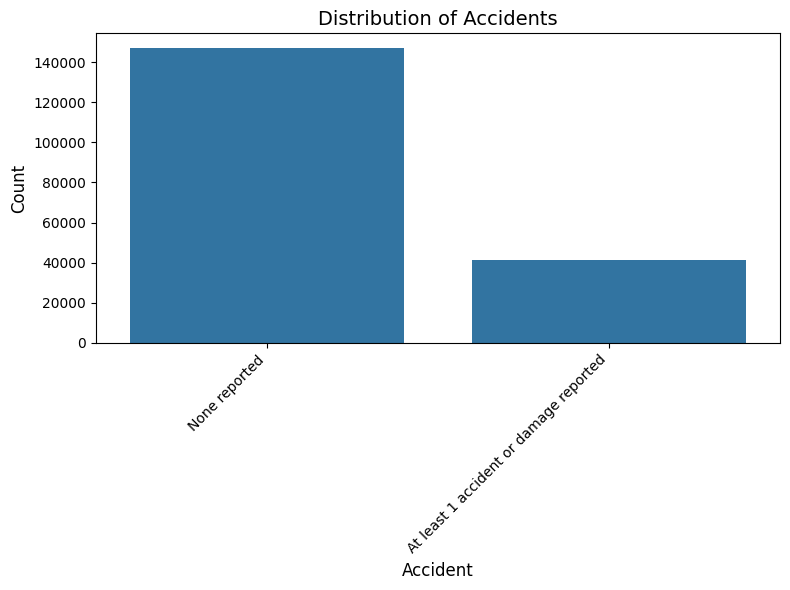

In [108]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='accident', order=train['accident'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Accidents", fontsize=14)
plt.xlabel("Accident", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

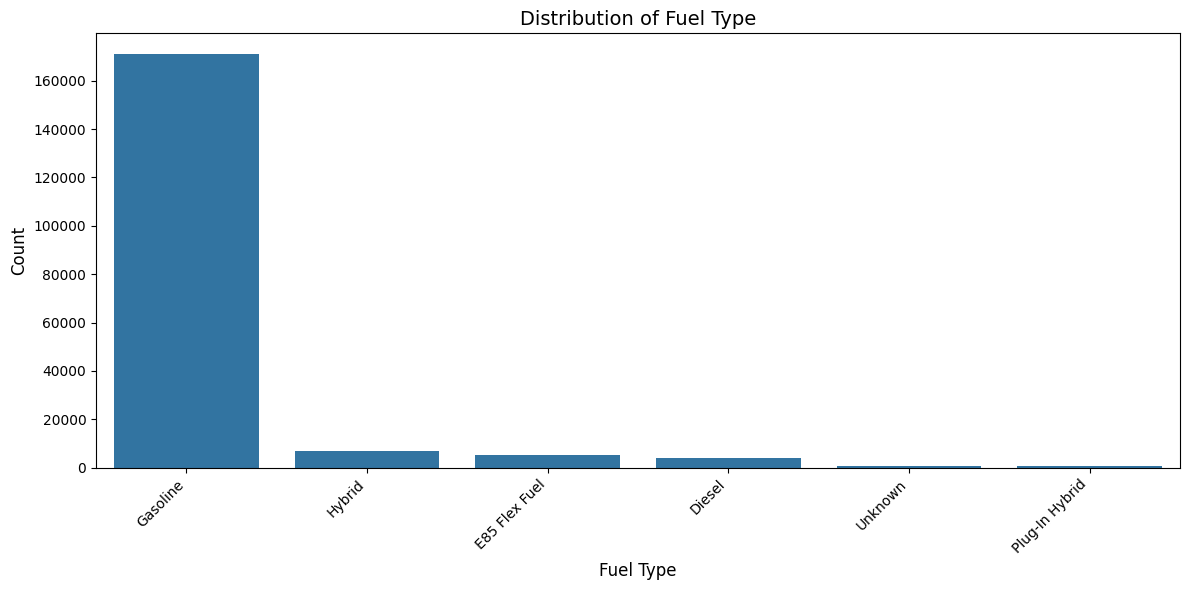

In [109]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='fuel_type', order=train['fuel_type'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Fuel Type", fontsize=14)
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

Feature Engineering

In [110]:
train['annual_mileage'] = train['milage'] / (2024 - train['model_year'] + 1)
test['annual_mileage'] = test['milage'] / (2024 - test['model_year'] + 1)
train['milage_age_interaction'] = train['milage'] * (2024 - train['model_year'])
test['milage_age_interaction'] = test['milage'] * (2024 - test['model_year'])
train['car_age'] = 2024 - train['model_year']
test['car_age'] = 2024 - test['model_year']

Logarithmic Transformation of Price and Milage Features


In [111]:
train['log_price'] = np.log1p(train['price'])
train['log_milage'] = np.log1p(train['milage'])
test['log_milage'] = np.log1p(test['milage'])

Creating a Mileage-Age Interaction



In [112]:
train['milage_age_interaction'] = train['milage'] * train['car_age']
test['milage_age_interaction'] = test['milage'] * test['car_age']

Detecting Outliers

In [113]:
def clip_outliers(df, col):
    lower_limit = df[col].quantile(0.05)
    upper_limit = df[col].quantile(0.95)
    df[col] = np.clip(df[col], lower_limit, upper_limit)
    return df

train = clip_outliers(train, 'milage')
train = clip_outliers(train, 'price')


Heatmap and Correlation

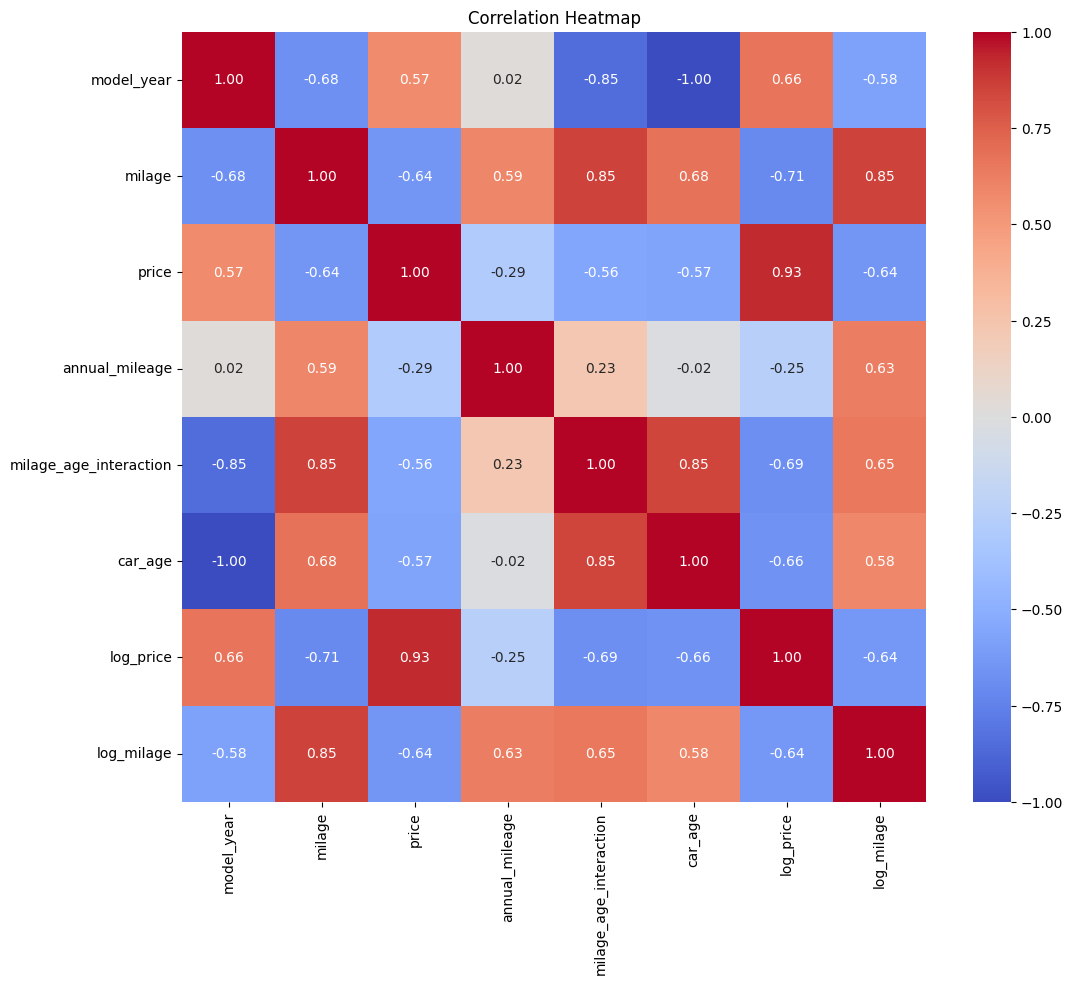

In [114]:
numerical_cols = train.select_dtypes(include=['number']).drop(columns=['id'], errors='ignore')



plt.figure(figsize=(12, 10))
correlation_matrix = numerical_cols.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

 Encode categorical features


In [115]:
objFeatures = train.select_dtypes(include='object').columns.to_list()
le = LabelEncoder()
for feature in objFeatures:
    train[feature] = le.fit_transform(train[feature])

objFeatures = test.select_dtypes(include='object').columns.to_list()
for feature in objFeatures:
    test[feature] = le.fit_transform(test[feature])

Min-Max scaling

In [116]:
scaler = MinMaxScaler()
numerical_cols = ['annual_mileage', 'milage_age_interaction', 'log_milage']
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

Train-Test Split


In [117]:
features = train.drop(columns=['price', 'log_price'], errors='ignore')
target = train['log_price']


In [118]:

X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

Linear Regression

In [119]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_val_pred_lr = model_lr.predict(X_val)
r2_lr = r2_score(y_val, y_val_pred_lr)
mae_lr = mean_absolute_error(np.expm1(y_val), np.expm1(y_val_pred_lr))
print(f"Linear Regression Validation R^2: {r2_lr:.4f}")
print(f"Linear Regression Validation MAE: {mae_lr:.2f}")

Linear Regression Validation R^2: 0.6175
Linear Regression Validation MAE: 18335.39


XGBoost

In [120]:
model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)
y_val_pred_xgb = model_xgb.predict(X_val)
r2_xgb = r2_score(y_val, y_val_pred_xgb)
mae_xgb = mean_absolute_error(np.expm1(y_val), np.expm1(y_val_pred_xgb))
print(f"XGBoost Validation R^2: {r2_xgb:.4f}")
print(f"XGBoost Validation MAE: {mae_xgb:.2f}")

XGBoost Validation R^2: 0.6614
XGBoost Validation MAE: 17147.83


In [121]:
if r2_xgb > r2_lr:
    model = model_xgb
    print("Using XGBoost")
else:
    model = model_lr
    print("Using Linear Regression")

Using XGBoost


Test Data Predictions








In [122]:
test_features = test[features.columns]

In [123]:
test_predictions = np.expm1(model.predict(test_features))

Histogram for Predicted prices Distribution

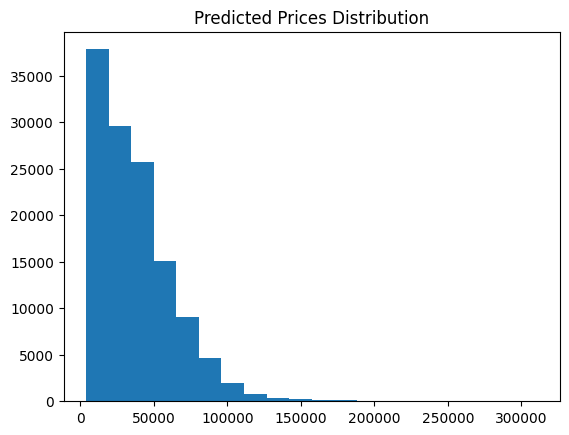

In [124]:
plt.hist(test_predictions, bins=20)
plt.title("Predicted Prices Distribution")
plt.show()

Accuracy

In [125]:

features = train.copy().drop("price", axis = 1)
price = train["price"].copy()

X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=0.2, shuffle=True)

model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)
score, error = r2_score(y_test, predict) , mean_absolute_error(y_test, predict)
print("Accuracy: ", score)
print("Error: ", error)

Accuracy:  0.8855382869227942
Error:  6581.351635511626


Saving File

In [126]:
sample = pd.read_csv("sample_submission.csv")
sample['price'] = test_predictions
sample.to_csv("sub.csv", index=False)
print("Submission saved as sub.csv")

Submission saved as sub.csv
